## A simple Framework for Masked image modelling 

Within the Vision Transformer (ViT) framework, the image is partitioned into N equal segments, each referred to as a token. These tokens play a crucial role in self-attention, where their significance is weighed. In the context of the paper `SimMIM` the approach involves masking select tokens and prompting the network to predict these masked tokens. The question arises: Does this strategy enhance the network's ability to learn more effective image representations?

We will see 
- How input image is masked?
- How learnable `Mask token` is introduced into the network?
- Additional ablation studies on SimMiM.

## Import Required Modules

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import fastcore.all as fc
from PIL import Image
from functools import partial
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, Compose, ToTensor, ToPILImage

import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline

> Lets create an image of size 192x192 with a patch size of 32

In [ ]:
img_size = 192
patch_size = 32

## load and visualize an image

we load and use `coco val` data. For this blog purpose, u can pick up any image of your choice from the internet.

In [ ]:
imgs = fc.L(fc.Path("../coco/val2017/").glob("*.jpg"))
imgs

(#5000) [Path('../coco/val2017/000000182611.jpg'),Path('../coco/val2017/000000335177.jpg'),Path('../coco/val2017/000000278705.jpg'),Path('../coco/val2017/000000463618.jpg'),Path('../coco/val2017/000000568981.jpg'),Path('../coco/val2017/000000092416.jpg'),Path('../coco/val2017/000000173830.jpg'),Path('../coco/val2017/000000476215.jpg'),Path('../coco/val2017/000000479126.jpg'),Path('../coco/val2017/000000570664.jpg')...]

> The following are the standard transforms mentioned in the paper.

In [ ]:
def transforms():
    return Compose([RandomResizedCrop(size=img_size, scale=[0.4, 1], ratio=[0.75, 1.33], interpolation=2), 
                    RandomHorizontalFlip(p=0.5), 
                    ToTensor()])

In [ ]:
def load_img(img_loc, transforms):
    img = Image.open(img_loc)
    return transforms(img)

load_img = partial(load_img, transforms=transforms())

In [ ]:
img = load_img(imgs[1])
img.shape

torch.Size([3, 192, 192])

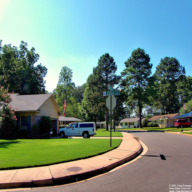

In [ ]:
ToPILImage()(img)

## How input data is set up for auto-regression?
An image is split into a grid of K non-overlapping patches which collectively form a sequence of tokens. since the image size is (192, 192) and patch size is (32, 32) we will get a total of 6x6 =36 patches. 

In [ ]:
imgp = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size).permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2))
imgp.shape

torch.Size([36, 3, 32, 32])

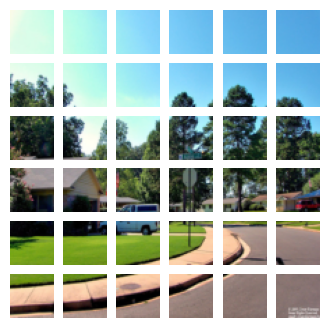

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), nrows=6, ncols=6)
for n, i in enumerate(imgp):
    ax.flat[n].imshow(ToPILImage()(i))
    ax.flat[n].axis("off")
plt.show()

## Randomly mask 50% of the patches 

> In the paper they have tried masking in different ways and found 50% to work consistently well in downstream tasks.

> Why 32 patches? when the patches are too small (4x4) the network can easily learn from the neighbouring pixels and when they are too large (64x64) the network looses context. In the paper, they calculated the distance between the pixel values within the mask area and pixels surrounding the mask area and found that 
    - fine-tuning accuracy increases linearly from 4-32 and drops from their.
    - mask predictions are more accurate at 4, 8, 16, 32 and looses context post that. 
    
so keeping them in mind lets randomly mask some the patches

In [ ]:
tokens = imgp.shape[0]
mask_ratio = 0.5
mask_count = int(tokens* 0.5)
tokens, mask_count

(36, 18)

In [ ]:
mask_idx = torch.randperm(tokens)[:mask_count]
mask = torch.zeros(tokens).long()
mask[mask_idx] = 1
mask

tensor([1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1])

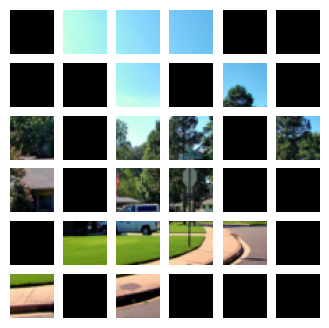

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), nrows=6, ncols=6)
for n, i in enumerate(imgp):
    if mask[n] == 1:
        i = torch.zeros(3, 32, 32)
    ax.flat[n].imshow(ToPILImage()(i))
    ax.flat[n].axis("off")
plt.show()

## Mask token.
The above is just for the illustration. In the original paper implementation, the authors first use a conv layer to convert each patch into a N dimensional vector using `kernel_size = stride = patch_size`. Now, the corresponding masked patches are replaced with a `learnable mask token`. we will see how these are done. 

First lets use `PatchEmbed` to create N dim vector for each patch.

In [ ]:
from timm.layers.patch_embed import PatchEmbed
from timm.layers.pos_embed import 

In [ ]:
pe = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=3, embed_dim=768, norm_layer=nn.LayerNorm)
pe

PatchEmbed(
  (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
embed = pe(img.unsqueeze(0))
embed.shape

torch.Size([1, 36, 768])

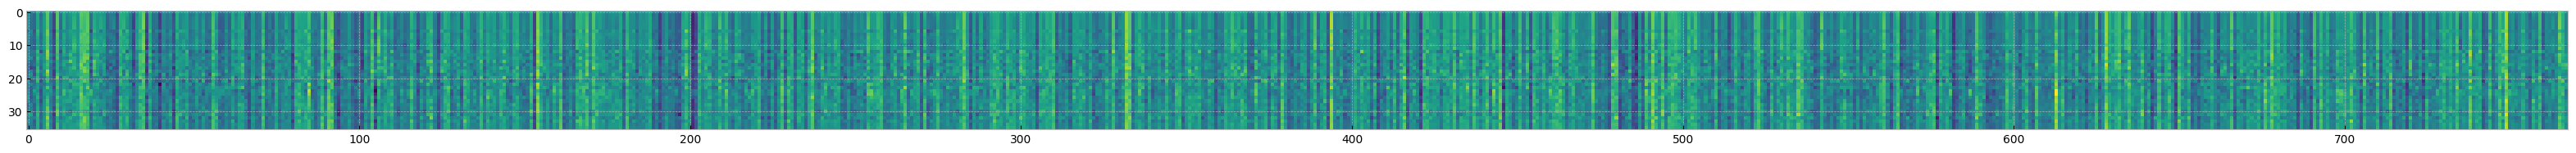

In [ ]:
plt.figure(figsize=(40, 8))
plt.imshow(embed[0].detach().numpy())
plt.show()

> Now lets define mask token and replace the masked portions of the image with it. 

In [ ]:
mask_token = nn.Parameter(torch.zeros(1, 1, 768))
mask_token.shape

torch.Size([1, 1, 768])

In [ ]:
w = mask.unsqueeze(-1).type_as(mask_token)
w.shape

torch.Size([36, 1])

In [ ]:
embed_masked = (embed * (1. - w) + mask_token * w)
embed_masked.shape

torch.Size([1, 36, 768])

In [ ]:
embed_masked[0].mean(axis=1), \
embed_masked[0].var(axis=1)

(tensor([ 0.0000e+00, -6.8297e-09,  1.0245e-08,  1.5522e-09,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -7.1401e-09,  0.0000e+00,
         -1.0555e-08,  0.0000e+00,  2.7940e-09,  0.0000e+00, -1.1176e-08,
         -5.5879e-09,  0.0000e+00, -5.5879e-09,  3.7253e-09,  0.0000e+00,
          6.2088e-10, -2.1731e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -1.4280e-08,  4.3462e-09,  9.3132e-09,  1.1176e-08,  0.0000e+00,
          1.4901e-08,  0.0000e+00,  1.5212e-08,  0.0000e+00,  0.0000e+00,
          0.0000e+00], grad_fn=<MeanBackward1>),
 tensor([0.0000, 1.0013, 1.0013, 1.0013, 0.0000, 0.0000, 0.0000, 0.0000, 1.0013,
         0.0000, 1.0012, 0.0000, 1.0007, 0.0000, 1.0012, 1.0011, 0.0000, 1.0011,
         1.0011, 0.0000, 1.0010, 1.0009, 0.0000, 0.0000, 0.0000, 1.0011, 1.0012,
         1.0012, 1.0012, 0.0000, 1.0012, 0.0000, 1.0012, 0.0000, 0.0000, 0.0000],
        grad_fn=<VarBackward0>))

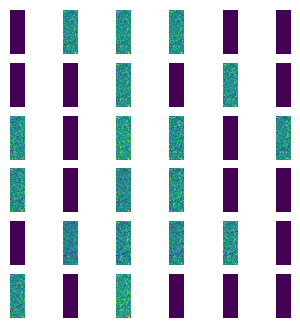

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), nrows=6, ncols=6)
for n, i in enumerate(embed_masked[0].reshape(-1, 48, 16)):
    ax.flat[n].imshow(i.detach().numpy())
    ax.flat[n].axis("off")
plt.show()

- So tokens are ready for each patch. Positional embeddings are added to these tokens and are sent to several `multi-head self-attention` blocks. The output of the self attention blocks is same as input in all transformer papers. So output is `[1, 36, 768]`. To understand more about self-attention and vision transformers see my other [blog](https://github.com/prakashjayy/computer_vision/blob/master/papers/vision_transformers.ipynb)

- using a single head conv layer, we convert each token into its original image. below we use out_channels as `patch_size^2 * n_channels`

In [ ]:
x = torch.randn((1, 36, 768))
B, L, C = x.shape
H = W = int(L ** 0.5)
x = x.permute(0, 2, 1).reshape(B, C, H, W)
x.shape

torch.Size([1, 768, 6, 6])

In [ ]:
decoder = nn.Sequential(
            nn.Conv2d(
                in_channels=768,
                out_channels=patch_size ** 2 * 3, kernel_size=1),
            nn.PixelShuffle(patch_size),
        )
decoder

Sequential(
  (0): Conv2d(768, 3072, kernel_size=(1, 1), stride=(1, 1))
  (1): PixelShuffle(upscale_factor=32)
)

In [ ]:
out = decoder(x)
out.shape

torch.Size([1, 3, 192, 192])

In [ ]:
out = out[0].unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size).permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2))
out.shape

torch.Size([36, 3, 32, 32])

> So finally we have input image, output image as token and a mask 

In [ ]:
imgp.shape, out.shape, mask.shape

(torch.Size([36, 3, 32, 32]), torch.Size([36, 3, 32, 32]), torch.Size([36]))

## loss 

we can use **l1 loss** to calculate the loss.

In [ ]:
x = imgp[mask.bool(), ...]
x_rec = out[mask.bool(), ...]
x_rec.shape, x.shape

(torch.Size([18, 3, 32, 32]), torch.Size([18, 3, 32, 32]))

In [ ]:
torch.nn.functional.l1_loss(x, x_rec, reduction='none').mean()

tensor(0.6751, grad_fn=<MeanBackward0>)

## End Points 
- Pre-training & Fine-tuning on Swin Transformers achieved 83% accuracy on image-net.
- Reconstruction loss is calculated only on **masked** patches.
- For prediction head, several decoders were tried and a simple 1 layer MLP/conv works better for downstream tasks.
- A random masking strategy worked better than `block-wise & square`.